# Multioutput Gaussian Processes in GPflow

This notebook shows how to construct a multi-output GP model using GPflow. We will consider a regression problem for functions $f: \mathbb{R}^D \rightarrow \mathbb{R}^P$. We assume that the dataset is of the form $(X, f_1), \dots, (X, f_P)$, that is, we observe all the outputs for a particular input location (for cases where there are **not** fully observed outputs for each input, see [A simple demonstration of coregionalisation](./coregionalisation.ipynb)).

Here we assume a model of the form: 
$$f(x) = W g(x),$$
where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$. We assume that the outputs of $g$ are uncorrelated, and that by *mixing* them with $W$ they become correlated. In this notebook, we show how to build this model using Sparse Variational Gaussian Process (SVGP) for $g$, which scales well with the numbers of data points and outputs. 

Here we have two options for $g$:
1. The output dimensions of $g$ share the same kernel.
2. Each output of $g$ has a separate kernel.


In addition, we have two further suboptions for the inducing inputs of $g$:
1. The instances of $g$ share the same inducing inputs.
2. Each output of $g$ has its own set of inducing inputs.

The notation is as follows:
$$
\newcommand{\GP}{\mathcal{GP}}
\newcommand{\NN}{\mathcal{N}}
\newcommand{\LL}{\mathcal{L}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\EE}{\mathbb{E}}
\newcommand{\valpha}{\boldsymbol\alpha}
\newcommand{\vf}{\mathbf{f}}
\newcommand{\vF}{\mathbf{F}}
\newcommand{\vg}{\mathbf{g}}
\newcommand{\vW}{\mathbf{W}}
\newcommand{\vI}{\mathbf{I}}
\newcommand{\vZ}{\mathbf{Z}}
\newcommand{\vu}{\mathbf{u}}
\newcommand{\vU}{\mathbf{U}}
\newcommand{\vX}{\mathbf{X}}
\newcommand{\vY}{\mathbf{Y}}
\newcommand{\identity}{\mathbb{I}}
$$
- $X \in \mathbb{R}^{N \times D}$ denotes the input
- $Y \in \RR^{N \times P}$ denotes the output
- $k_{1..L}$, $L$ are kernels on $\RR^{N \times D}$
- $g_{1..L}$, $L$ are independent $\GP$s  with $g_l \sim \GP(0,k_l)$
- $f_{1..P}$, $P$ are correlated  $\GP$s  with $\vf = \vW \vg$ 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf

from gpflow.utilities import print_summary

gpf.config.set_default_float(np.float64)
gpf.config.set_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline

MAXITER = gpf.test_util.notebook_niter(2000)

## Generate synthetic data
We create a utility function to generate synthetic data. We assume that:

In [2]:
N = 100 # number of points
D = 1  # number of input dimensions
M = 15  # number of inducing points
L = 2  # number of latent GPs
P = 3  # number of observations = output dimensions

In [3]:
def generate_data(N=100):
    X = np.random.rand(N)[:, None] * 10 - 5  # Inputs = N x D
    G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X)) # G = N x L
    W = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
    F = np.matmul(G, W)  # N x P
    Y = F + np.random.randn(*F.shape) * [0.2, 0.2, 0.2]
    
    return X, Y

In [4]:
X, Y = generate_data(N)
Zinit = np.linspace(-5, 5, M)[:, None]

We create a utility function for plotting:

In [5]:
def plot_model(m, lower=-8.0, upper=8.0):
    pX = np.linspace(lower, upper, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(X, Y, 'x')
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
    plt.xlabel('X')
    plt.ylabel('f')
    plt.title(f"lml: {m.log_likelihood(X, Y):.3}")
    plt.plot(Z, Z * 0.0, 'o')

## Modelling the outputs $f(x)$ directly
In the three examples below, we will show how to model the outputs of the model $f(x)$ directly. Mathematically, this case is equivalent to having:
$$
f(x) = I g(x),
$$
i.e. $W = I$ and $P = L$.

### 1. Shared Independent MultiOutput Kernel (MOK) & Shared Independent Inducing Variables

In [6]:
# create multioutput kernel
kernel = gpf.kernels.SharedIndependent(gpf.kernels.RBF(1) + gpf.kernels.Linear(1), output_dimensionality=P) 
# initialisation of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multioutput inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(gpf.inducing_variables.InducingPoints(Z)) 

In [7]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variables=iv, num_latent=P)

In [9]:
res = gpf.optimizers.Scipy().minimize(
    lambda: -m.log_likelihood(X, Y), 
    variables=m.trainable_variables,
    method="l-bfgs-b", 
    options={"disp": True, "maxiter": MAXITER}
)

In [11]:
print_summary(m)

name,class,transform,trainable,shape,dtype,value
SVGP.kernel.kernel.Sum_kernels[0].variance,Parameter,Softplus,True,(),float64,0.9277346544719383
SVGP.kernel.kernel.Sum_kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.7983102383673745
SVGP.kernel.kernel.Sum_kernels[1].variance,Parameter,Softplus,True,(),float64,1.2114172982330587
SVGP.likelihood.variance,Parameter,Softplus,True,(),float64,0.03966024302139383
SVGP.inducing_variables.inducing_variable_shared.Z,Parameter,,True,"(15, 1)",float64,[[-4.83945878...
SVGP.q_mu,Parameter,,True,"(15, 3)",float64,"[[-0.90182527, 0.69918339, -1.47536573..."
SVGP.q_sqrt,Parameter,FillTriangular,True,"(3, 15, 15)",float64,"[[[1.71241694e-02, 0.00000000e+00, 0.00000000e+00..."


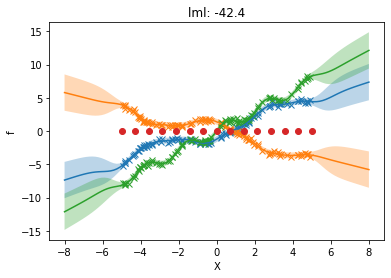

In [12]:
# Plot predictions and observations
plot_model(m)

In [13]:
print_summary(m.kernel)
m.kernel.kernel.kernels[0].lengthscale

name,class,transform,trainable,shape,dtype,value
SharedIndependent.kernel.Sum_kernels[0].variance,Parameter,Softplus,True,(),float64,0.927735
SharedIndependent.kernel.Sum_kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.79831
SharedIndependent.kernel.Sum_kernels[1].variance,Parameter,Softplus,True,(),float64,1.21142


<tf.Tensor: id=1724854, shape=(), dtype=float64, numpy=0.7983102383673745>

### 2. Separate Independent MOK & Shared Independent Inducing Variables

In [14]:
# Create list of kernels for each output
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
# Create multioutput kernel from kernel list
kernel = gpf.kernels.SeparateIndependent(kern_list)
# initialisation of inducing input locations (M random points from the training inputs)
Z = Zinit.copy() 
# create multioutput inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(gpf.inducing_variables.InducingPoints(Z))

In [15]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variables=iv, num_latent=P)

In [16]:
res = gpf.optimizers.Scipy().minimize(
    lambda: -m.log_likelihood(X, Y),
    variables=m.trainable_variables,
    method="l-bfgs-b",
    options={"disp": True, "maxiter": min(2500, MAXITER)}
)

In [17]:
print_summary(m.kernel)

name,class,transform,trainable,shape,dtype,value
SeparateIndependent.SeparateIndependent_kernels[0].Sum_kernels[0].variance,Parameter,Softplus,True,(),float64,0.861639
SeparateIndependent.SeparateIndependent_kernels[0].Sum_kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.934342
SeparateIndependent.SeparateIndependent_kernels[0].Sum_kernels[1].variance,Parameter,Softplus,True,(),float64,0.859601
SeparateIndependent.SeparateIndependent_kernels[1].Sum_kernels[0].variance,Parameter,Softplus,True,(),float64,0.751142
SeparateIndependent.SeparateIndependent_kernels[1].Sum_kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.969109
SeparateIndependent.SeparateIndependent_kernels[1].Sum_kernels[1].variance,Parameter,Softplus,True,(),float64,0.528743
SeparateIndependent.SeparateIndependent_kernels[2].Sum_kernels[0].variance,Parameter,Softplus,True,(),float64,1.11298
SeparateIndependent.SeparateIndependent_kernels[2].Sum_kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.749411
SeparateIndependent.SeparateIndependent_kernels[2].Sum_kernels[1].variance,Parameter,Softplus,True,(),float64,2.20632


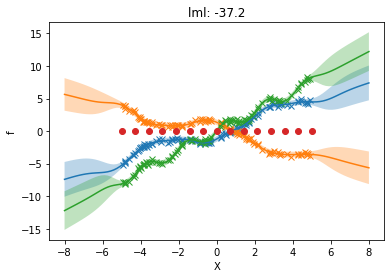

In [18]:
plot_model(m)

In [19]:
[k.kernels[0].lengthscale for k in m.kernel.kernels]

[<tf.Tensor: id=6034436, shape=(), dtype=float64, numpy=0.9343418843721769>,
 <tf.Tensor: id=6034439, shape=(), dtype=float64, numpy=0.9691094916596998>,
 <tf.Tensor: id=6034442, shape=(), dtype=float64, numpy=0.7494109053786279>]

### 3. Separate Independent Kernel & Separate Independent Inducing Variables

In [21]:
# Create list of kernels for each output
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
# Create multioutput kernel from kernel list
kernel = gpf.kernels.SeparateIndependent(kern_list)
# initialisation of inducing input locations, one set of locations per output
Zs = [Zinit.copy() for _ in range(P)]
# initialise as list inducing inducing variables
iv_list = [gpf.inducing_variables.InducingPoints(Z) for Z in Zs]
# create multioutput inducing variables from iv_list
iv = gpf.inducing_variables.SeparateIndependentInducingVariables(iv_list)

**NOTE:** While the inducing points are independent, there needs to be the same number of inducing points per dimension.

In [22]:
# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variables=iv, num_latent=P)

In [23]:
res = gpf.optimizers.Scipy().minimize(
    lambda: -m.log_likelihood(X, Y), 
    variables=m.trainable_variables,
    method="l-bfgs-b", 
    options={"disp": True, "maxiter": MAXITER}
)

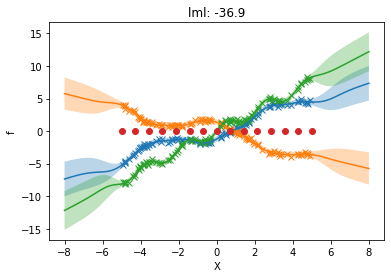

In [24]:
plot_model(m)

The plot below shows that we use different inducing *inputs* in each output dimension.

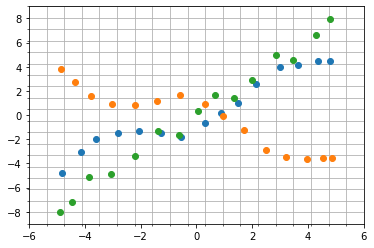

In [25]:
for i in range(len(m.inducing_variables.inducing_variable_list)):
    q_mu_unwhitened, q_var_unwhitened = m.predict_f(m.inducing_variables.inducing_variable_list[i].Z)
    plt.plot(m.inducing_variables.inducing_variable_list[i].Z.numpy(), q_mu_unwhitened[:, i, None].numpy(), "o")
plt.gca().set_xticks(np.linspace(-6, 6, 20), minor=True)
plt.gca().set_yticks(np.linspace(-9, 9, 20), minor=True)
plt.grid(which='minor')

In [26]:
m.inducing_variables.inducing_variable_list

ListWrapper([<gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x7fd500625ed0>, <gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x7fd501193450>, <gpflow.inducing_variables.inducing_variables.InducingPoints object at 0x7fd5010e3750>])

## Modelling $f(x)$ by doing inference in the $g$ space
### Mixed Kernel & Uncorrelated Inducing Variables 

Remember the general case: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$, where $L \leq P$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
With this setup we perform the optimal routine to calculate the conditional. Namely, calculate the conditional of the uncorrelated latent $g$ and afterwards project the mean and variance using the mixing matrix: $\mu_f = W \mu_g$ and $\Sigma_f = W\Sigma_g W^\top$

- $ K_{uu} = L \times M \times M $
- $ K_{uf} = L \times M \times N $

In [27]:
# Create list of kernels for each output
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
# Create multioutput kernel from kernel list
kernel = gpf.kernels.LinearCoregionalization(kern_list, W=np.random.randn(P, L)) # Notice that we initialise the mixing matrix W
# initialisation of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multioutput inducing variables from Z
iv = gpf.inducing_variables.SharedIndependentInducingVariables(gpf.inducing_variables.InducingPoints(Z))

In [28]:
# initialise mean of variational posterior to be of shape MxL
q_mu = np.zeros((M, L)) 
# initialise \sqrt(Σ) of variational posterior to be of shape LxMxM
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0 

# create SVGP model as usual and optimize
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variables=iv, q_mu=q_mu, q_sqrt=q_sqrt)

In [29]:
res = gpf.optimizers.Scipy().minimize(
    lambda: -m.log_likelihood(X, Y), 
    variables=m.trainable_variables,
    method="l-bfgs-b", 
    options={"disp": True, "maxiter": MAXITER}
)

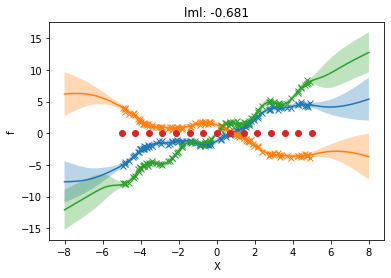

In [30]:
plot_model(m)

## Illustration of GPflow's Multioutput Capabilities

### Multioutput Kernels class diagram
![new_multioutput_gp_kernels.png](./new_multioutput_gp_kernels.png)




### Multioutput Inducing Variables class diagram

![new_multioutput_gp_features.png](./new_multioutput_gp_features.png)

**NOTE:** `MixedKernelSeparateMof` is not implemented, but can easily be added to the framework.

The shape of Kuu and Kuf and the underlying conditional code depends on the Mof and Mok classes used.

| Feature                | Kernel                        | Kuu           | Kuf           | conditional                     | note                                                                                                                                                                                                            |
|------------------------|-------------------------------|---------------|---------------|---------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| InducingPoints         | Mok  | MxPxMxP | MxPxNxP | fully_correlated_conditional    | This is the default. For certain kernels this is very inefficient. In this case q_mu and q_sqrt are 1 x MP and 1 x MP x MP                                                                                                                                              |
| SharedIndependentMof   | SharedIndependentMok          | M x M         | M x N         | base_conditional                | These two classes are in a sense redundant, because we can achieve the same behaviour by using the single output Kernel and InducingFeature classes. They are added for illustrative purposes. Thanks to the conditional dispatch, the most efficient code path is used.                          |
| SeparateIndependentMof | SharedIndependentMok          | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                       |
| SharedIndependentMof   | SeparateIndependentMok        | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                                                                 |
| SeparateIndependentMof | SeparateIndependentMok        | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                                                                |
| SharedIndependentMof   | SeparateMixedKernel           | L x M x M     | M x L x N x P | independent_interdomain_conditional | Inducing outputs live in g-space                                                                                                                                                                                |
| SeparateIndependentMof | SeparateMixedKernel           | L x M x M     | M x L x N x P | independent_interdomain_conditional | Very similar to the above                                                                                                                                                                                           |
| MixedKernelSharedMof   | SeparateMixedKernel           | L x M x M     | L x M x N     | base_conditional                 | This is the most efficient implementation for MixedKernels.  The inducing outputs live in g-space. Here we use the output of the base conditional and project the mean and covariance with the mixing matrix W. |

## Further Reading:
- [Coregionalisation](./coregionalisation.ipynb), which details other GPflow features for multi-output prediction without fully observed outputs.